# Gaussian Mixture Model Tutorial 

In [13]:
#import requred libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.stats import norm
import warnings
import random
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


## Generating Normal Distribution 

In [26]:
# Generate some data with multiple modes
data1 = np.random.normal(0, 1, 1000)
data2 = np.random.normal(5, 1, 1000)


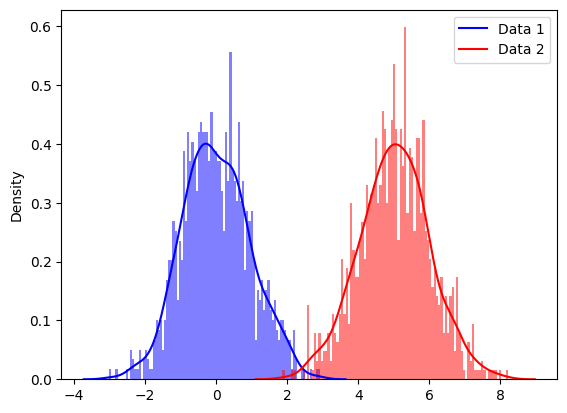

In [27]:

# Plot the data using seaborn's distplot function
sns.distplot(data1, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})
sns.distplot(data2, kde=True, hist=True, bins=100, color='r', hist_kws={'alpha': 0.5})

# Add a legend
plt.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [11]:
data2[:3]

array([3.6591822 , 4.20130871, 6.49824233])

## Multivariable Normal Distribution 

In [28]:
# Set the mean and covariance
mean1 = [0, 0]
mean2 = [2, 0]
cov1 = [[1, .7], [.7, 1]]
cov2 = [[.5, .4], [.4, .5]]

In [29]:

# Generate data from the mean and covariance
data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
data2 = np.random.multivariate_normal(mean2, cov2, size=1000)

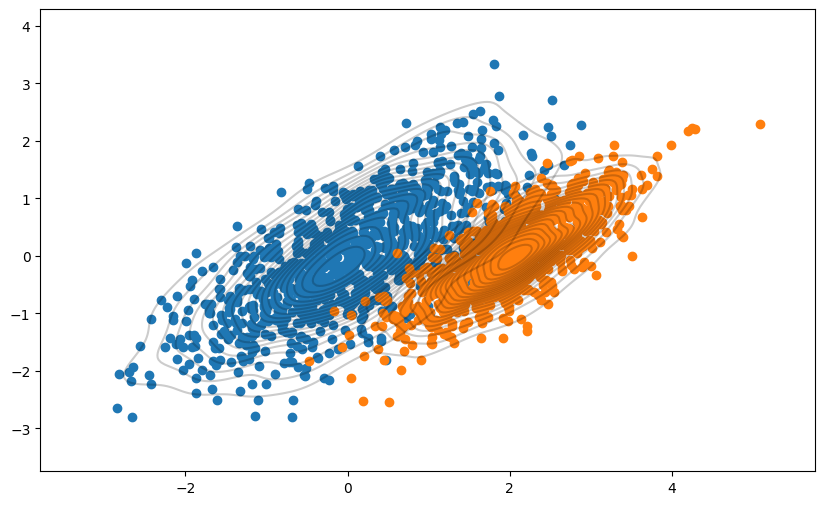

In [33]:
plt.figure(figsize=(10,6))

plt.scatter(data1[:, 0], data1[:, 1])
plt.scatter(data2[:, 0], data2[:, 1])

sns.kdeplot(x=data1[:, 0], y=data1[:, 1], levels=20, linewidths=1.5, color='k', alpha=0.2)
sns.kdeplot(x=data2[:, 0], y=data2[:, 1], levels=20, linewidths=1.5, color='k', alpha=0.2)

plt.grid(False)
plt.show()

## Generating Fake data to implment GMM 

In [34]:
n_samples = 100
mu1, sigma1 = -5, 1.2 
mu2, sigma2 = 5, 1.8 
mu3, sigma3 = 0, 1.6 

x1 = np.random.normal(loc = mu1, scale = np.sqrt(sigma1), size = n_samples)
x2 = np.random.normal(loc = mu2, scale = np.sqrt(sigma2), size = n_samples)
x3 = np.random.normal(loc = mu3, scale = np.sqrt(sigma3), size = n_samples)

X = np.concatenate((x1,x2,x3))

In [38]:
len(X)

300

### Implement GMM 

In [35]:
def plot_pdf(mu,sigma,label,alpha=0.5,linestyle='k--',density=True,color='green'):
    """
    Plot 1-D data and its PDF curve.

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The input data.
    """
    # Compute the mean and standard deviation of the data

    # Plot the data
    
    X = norm.rvs(mu, sigma, size=1000)
    
    plt.hist(X, bins=50, density=density, alpha=alpha,label=label,color=color)

    # Plot the PDF
    x = np.linspace(X.min(), X.max(), 1000)
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, linestyle)

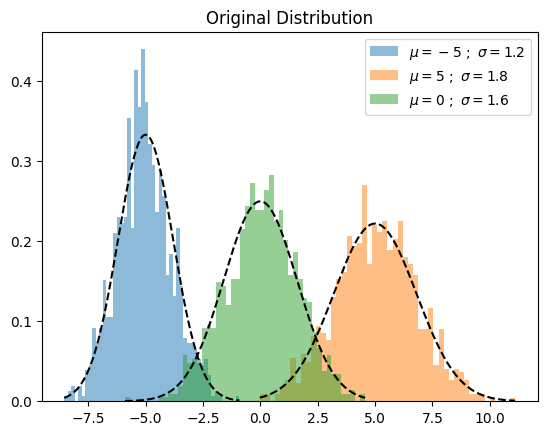

In [36]:
plot_pdf(mu1,sigma1,label=r"$\mu={} \ ; \ \sigma={}$".format(mu1,sigma1),color=None)
plot_pdf(mu2,sigma2,label=r"$\mu={} \ ; \ \sigma={}$".format(mu2,sigma2),color=None)
plot_pdf(mu3,sigma3,label=r"$\mu={} \ ; \ \sigma={}$".format(mu3,sigma3),color=None)
plt.title("Original Distribution")
plt.legend()
plt.show()

## STEP 01: Initialize Mean, Covariance and Weight 

In [39]:
def random_init(n_compenents):
    
    """Initialize means, weights and variance randomly"""
    
    pi = np.ones((n_compenents)) / n_compenents
    means = np.random.choice(X, n_compenents)
    variances = np.random.random_sample(size=n_compenents)
    plot_pdf(means[0],variances[0],'Random Init 01',)
    plot_pdf(means[1],variances[1],'Random Init 02',color='blue')
    plot_pdf(means[2],variances[2],'Random Init 03',color='orange')
    
    plt.title("Random Initialization")
    
    plt.legend()
    plt.show()
    
    return means,variances,pi

## STEP 2: Expectation Step (ES)

In [44]:
def step_expectation(X,n_components,means,variances):
    """E Step
    
    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The data.
    n_components : int
        The number of clusters
    means : array-like, shape (n_components,)
        The means of each mixture component.
    variances : array-like, shape (n_components,)
        The variances of each mixture component.
        
    Returns
    -------
    weights : array-like, shape (n_components,n_samples)
    """
    weights = np.zeros((n_components,len(X)))
    for j in range(n_components):
        weights[j,:] = norm(loc=means[j],scale=np.sqrt(variances[j])).pdf(X)
    return weights

## STEP 3: Maximize Step 

In [45]:
def step_maximization(X,weights,means,variances,n_compenents,pi):
    """M Step
    
    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The data.
    weights : array-like, shape (n_components,n_samples)
        initilized weights array
    means : array-like, shape (n_components,)
        The means of each mixture component.
    variances : array-like, shape (n_components,)
        The variances of each mixture component.
    n_components : int
        The number of clusters
    pi: array-like (n_components,)
        mixture component weights
        
    Returns
    -------
    means : array-like, shape (n_components,)
        The means of each mixture component.
    variances : array-like, shape (n_components,)
        The variances of each mixture component.
    """
    r = []
    for j in range(n_compenents):  
        r.append((weights[j] * pi[j]) / (np.sum([weights[i] * pi[i] for i in range(n_compenents)], axis=0)))

        means[j] = np.sum(r[j] * X) / (np.sum(r[j]))
        variances[j] = np.sum(r[j] * np.square(X - means[j])) / (np.sum(r[j]))
    
        pi[j] = np.mean(r[j])

    return variances,means,pi

In [46]:
def plot_intermediate_steps(means,variances,density=False,save=False,file_name=None):
    
    plot_pdf(mu1,sigma1,alpha=0.0,linestyle='r--',label='Original Distibutions')
    plot_pdf(mu2,sigma2,alpha=0.0,linestyle='r--',label='Original Distibutions')
    plot_pdf(mu3,sigma3,alpha=0.0,linestyle='r--',label='Original Distibutions')
    
    color_gen = (x for x in ['green','blue','orange'])
    
    for mu,sigma in zip(means,variances):
        plot_pdf(mu,sigma,alpha=0.5,label='d',color=next(color_gen))
    if save or file_name is not None:
        step = file_name.split("_")[1]
        plt.title(f"step: {step}")
        plt.savefig(f"steps/{file_name}.png",bbox_inches='tight')
    plt.show()

In [48]:
def train_gmm(data,n_compenents=3,n_steps=50, plot_intermediate_steps_flag=True):
    """ Training step of the GMM model
    
    Parameters
    ----------
    data : array-like, shape (n_samples,)
        The data.
    n_components : int
        The number of clusters
    n_steps: int
        number of iterations to run
    """
    
    
    means,variances,pi = random_init(n_compenents)
    for step in range(n_steps):
        weights = step_expectation(data,n_compenents,means,variances)
        variances,means,pi = step_maximization(X, weights, means, variances, n_compenents, pi)
        if plot_intermediate_steps_flag:plot_intermediate_steps(means,variances,)#file_name=f'step_{step+1}')
        plot_intermediate_steps(means,variances)

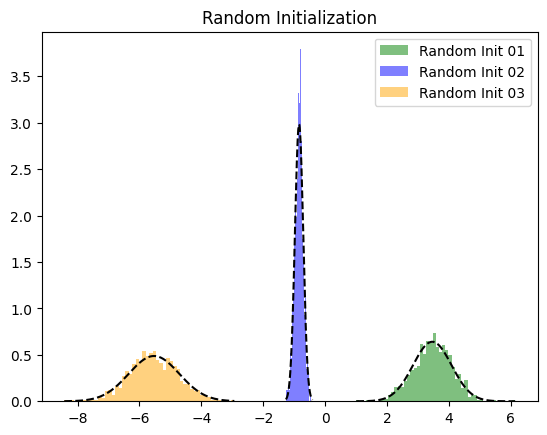

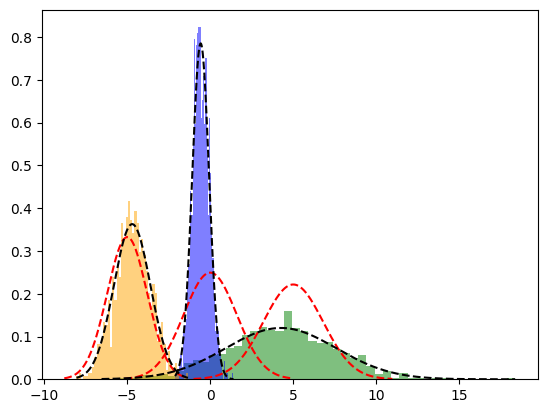

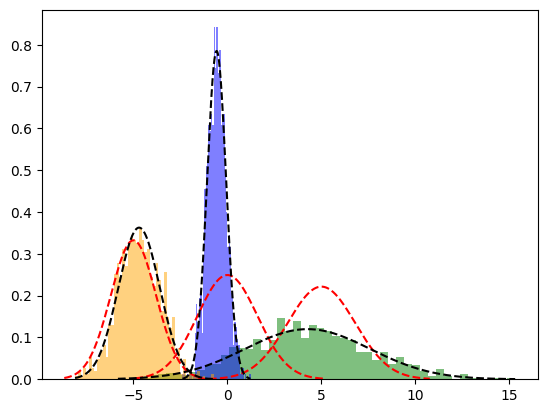

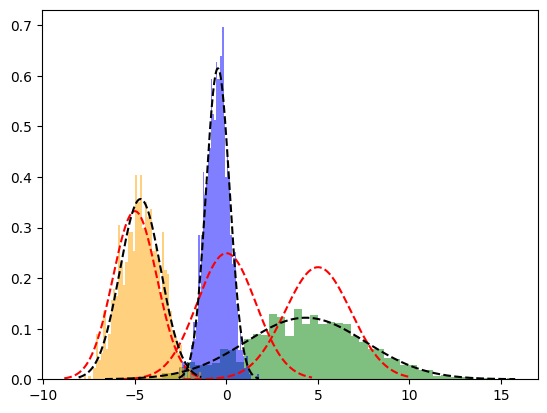

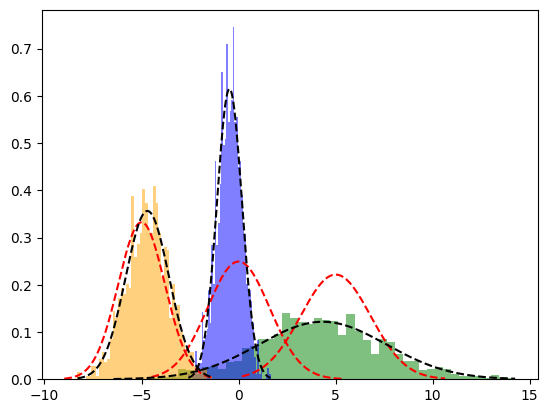

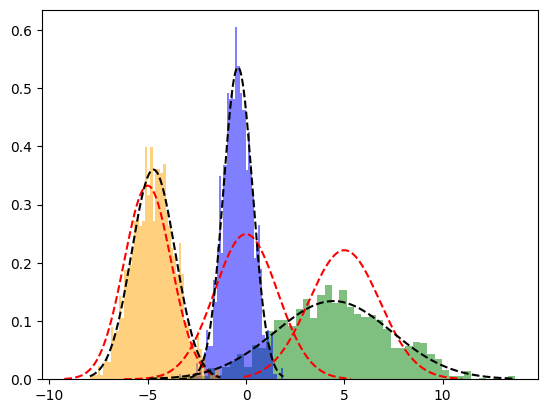

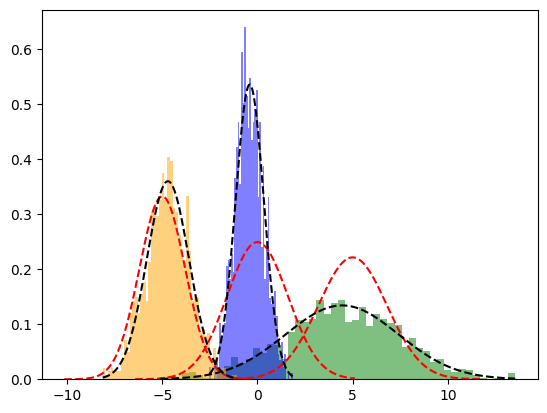

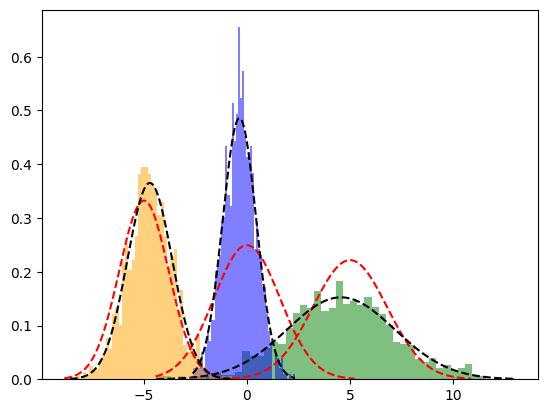

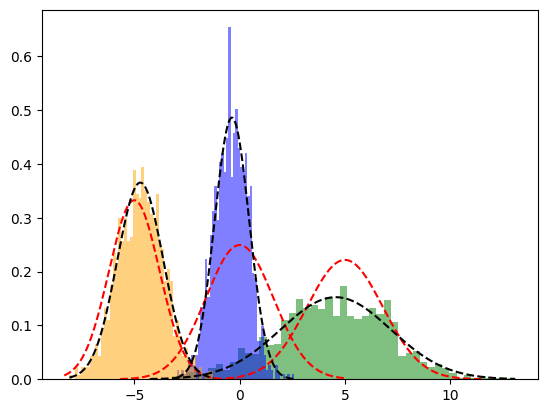

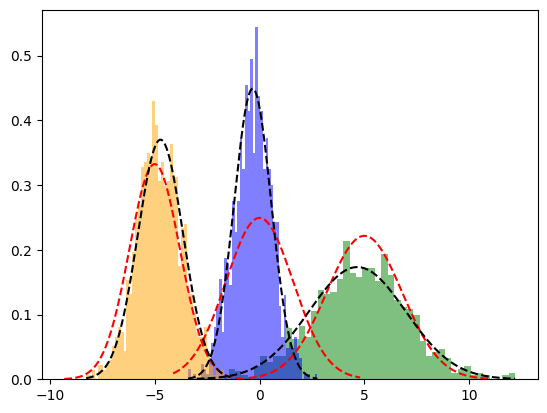

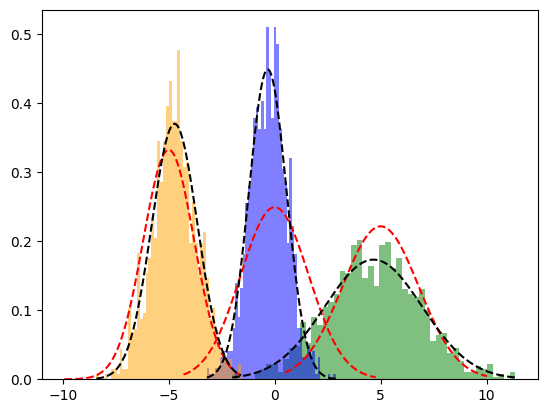

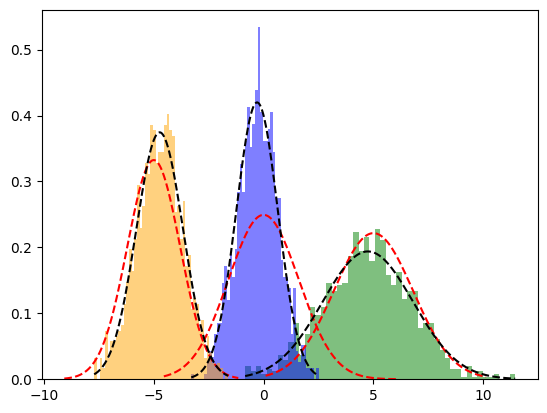

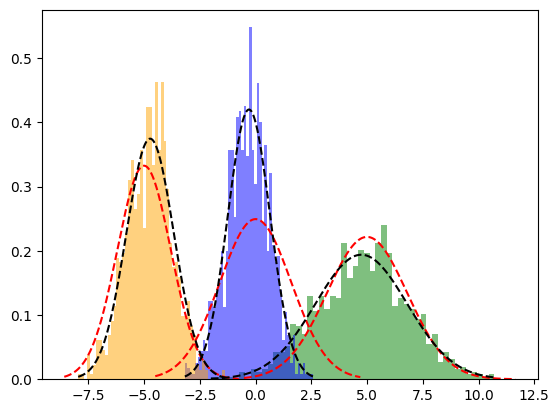

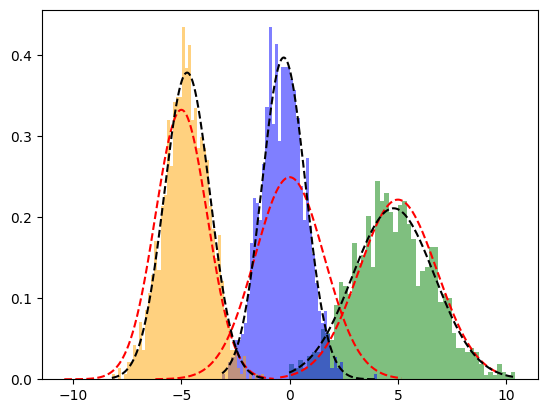

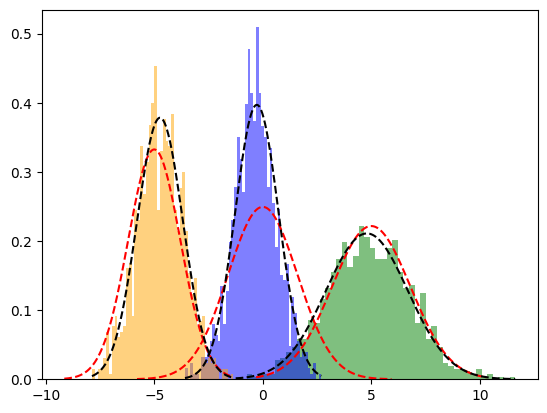

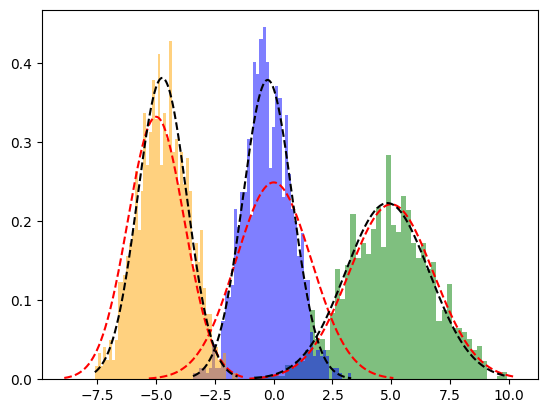

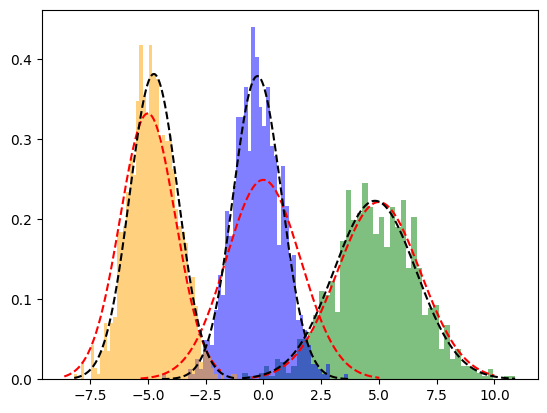

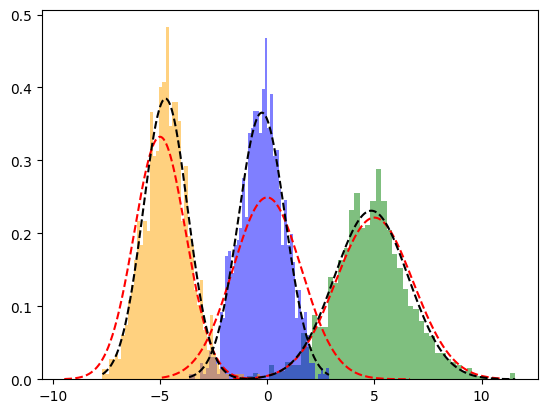

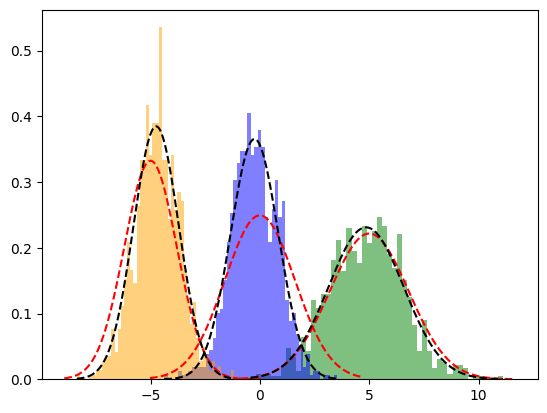

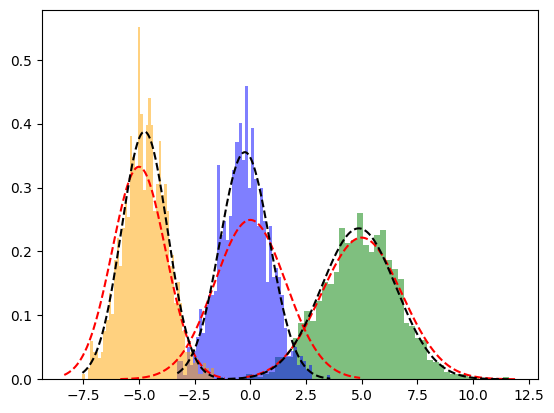

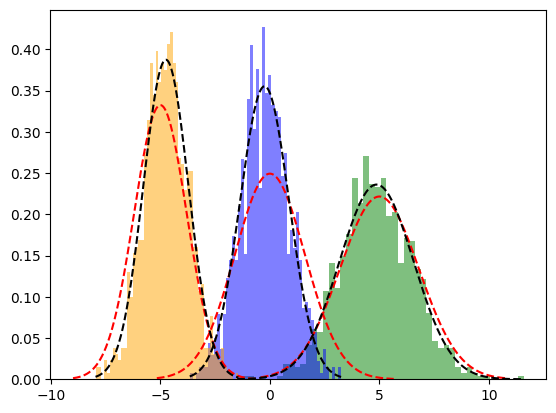

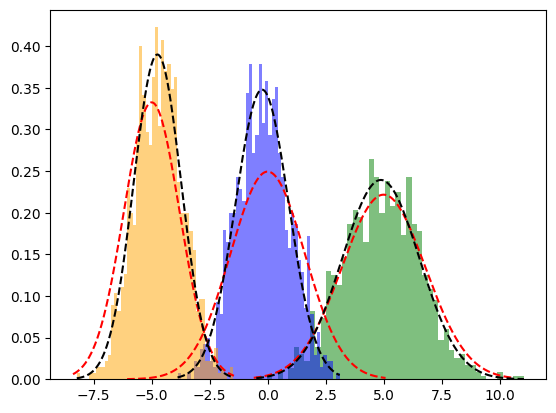

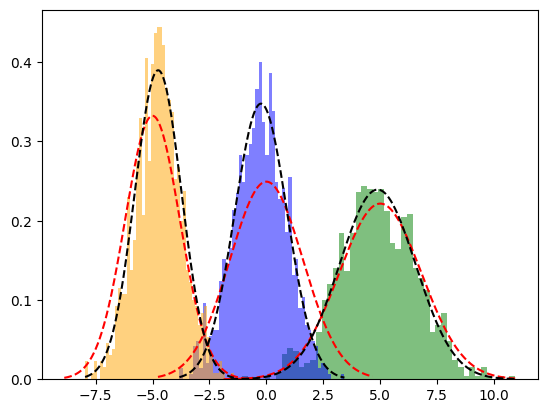

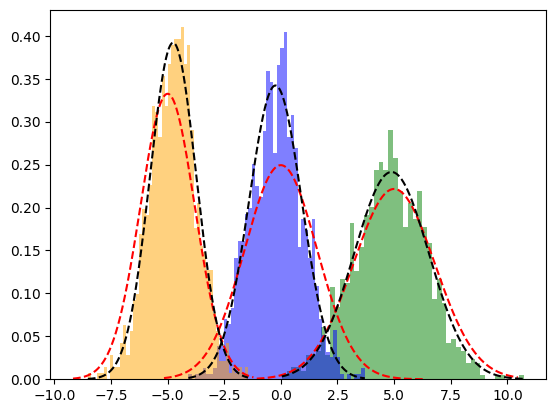

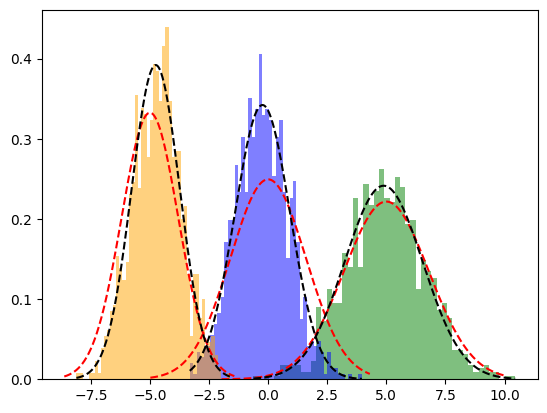

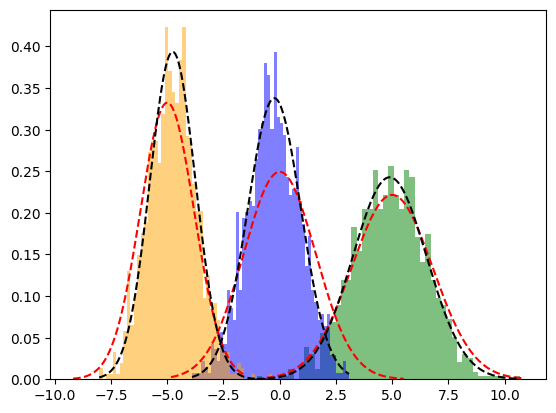

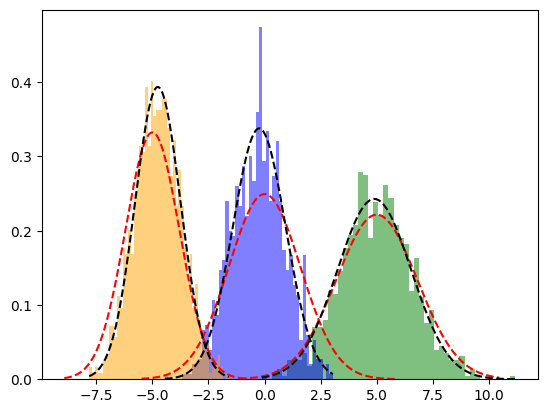

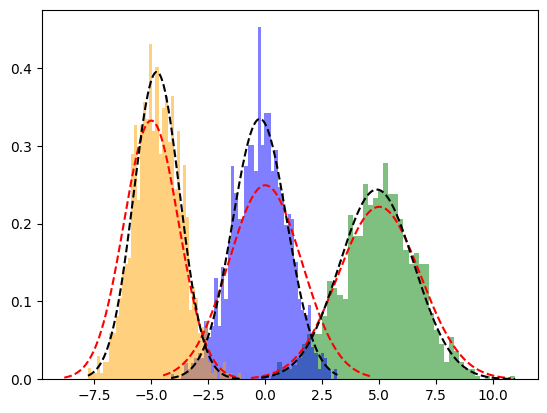

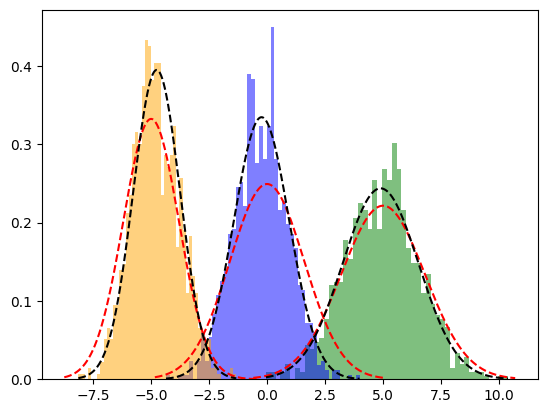

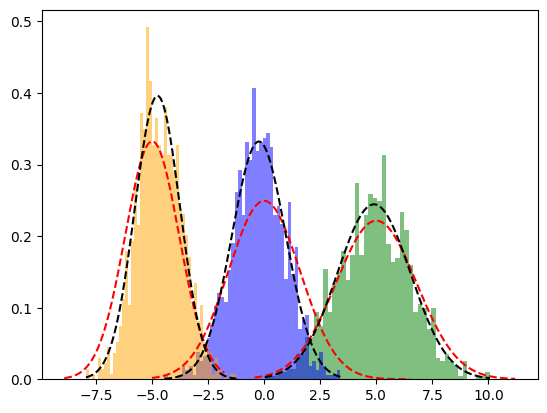

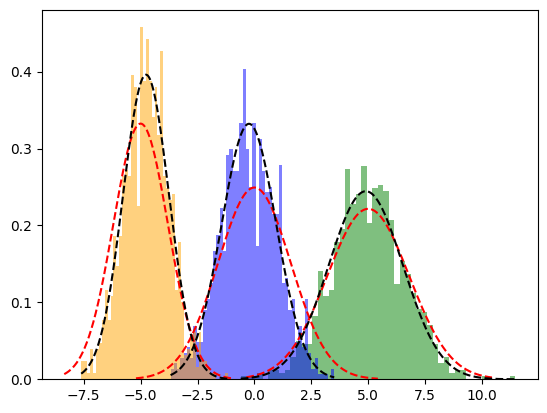

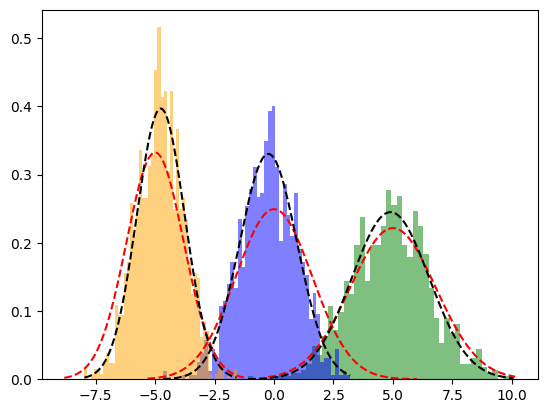

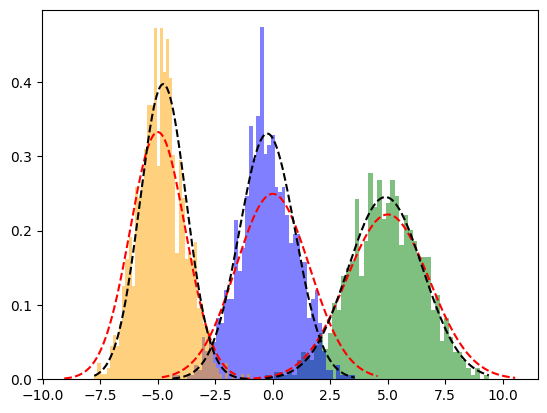

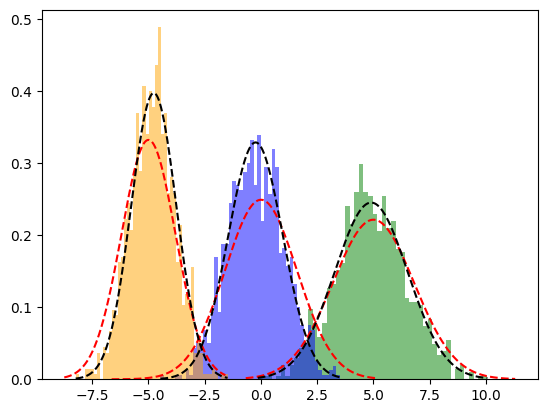

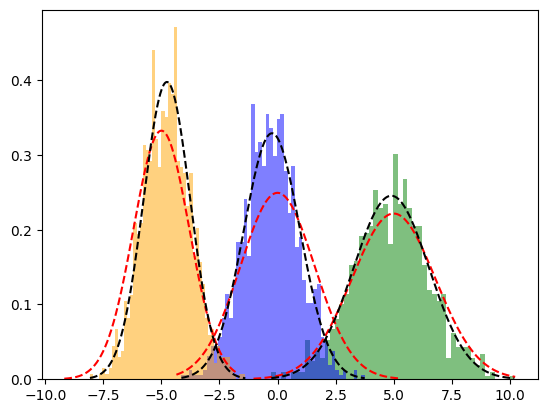

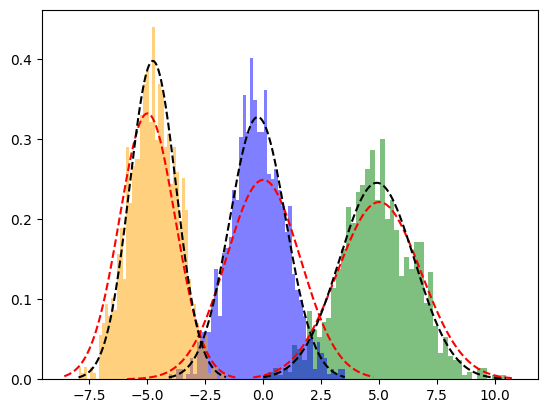

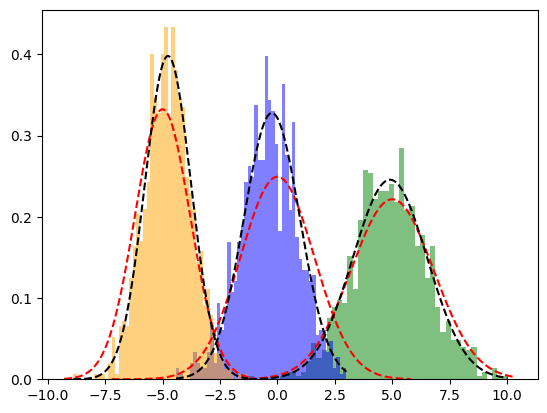

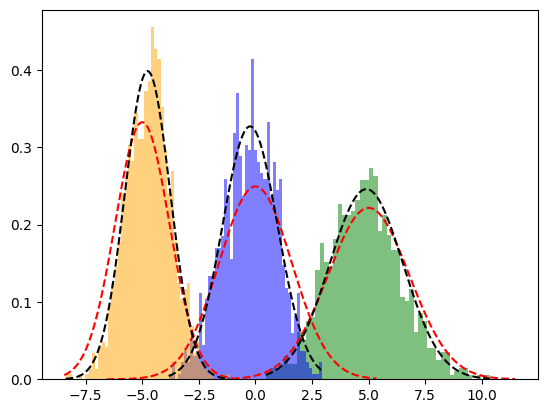

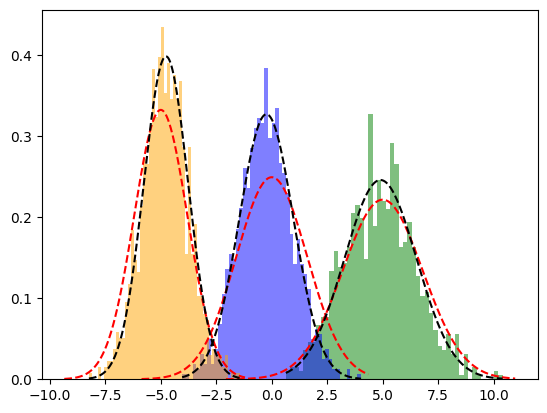

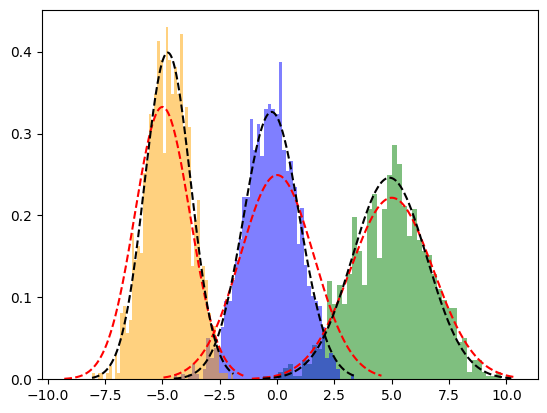

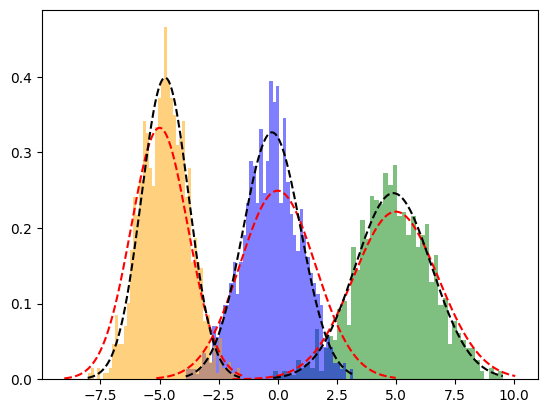

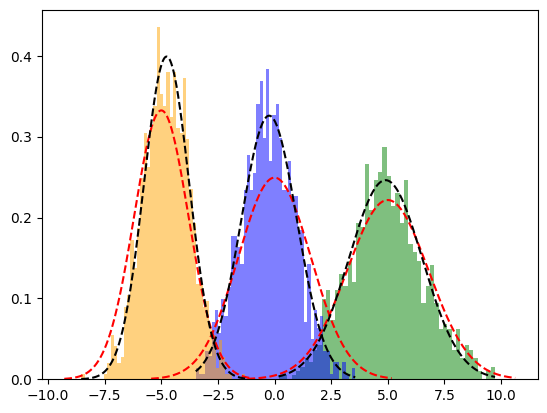

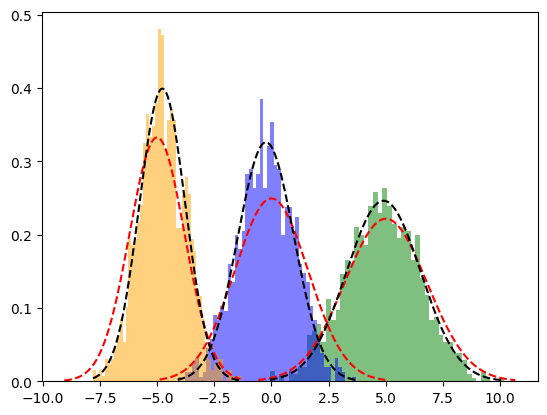

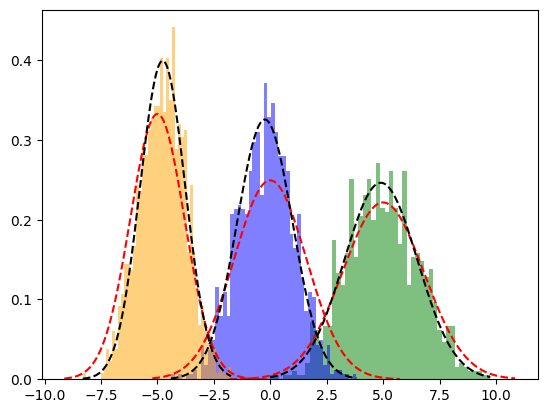

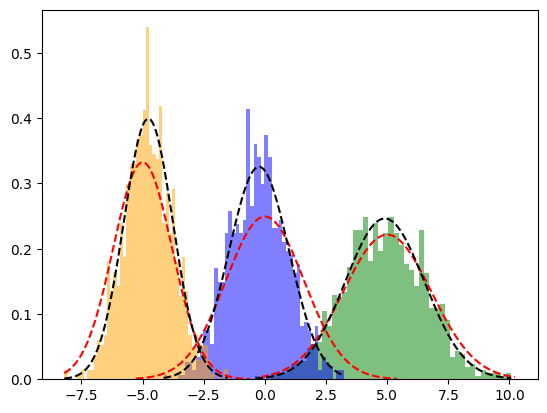

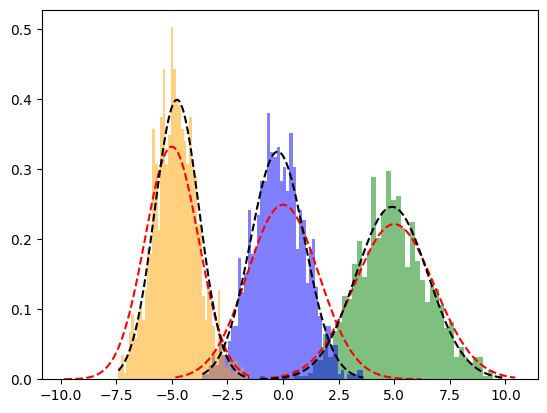

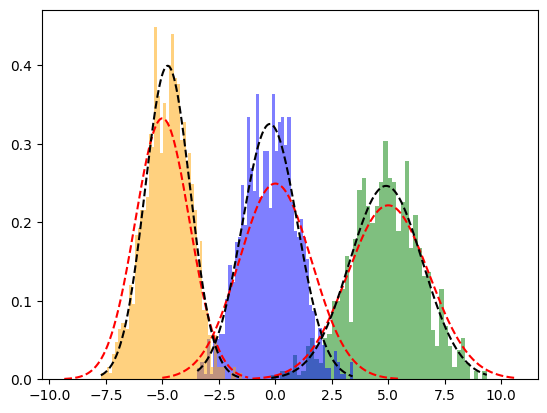

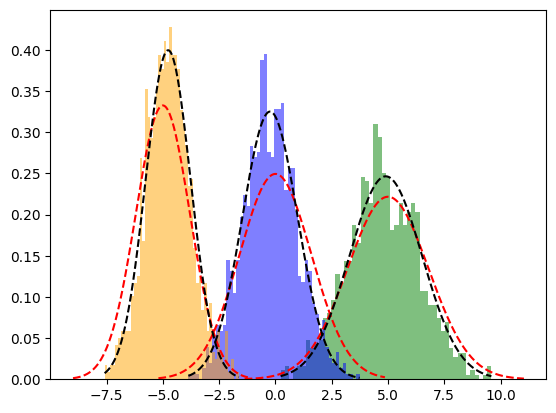

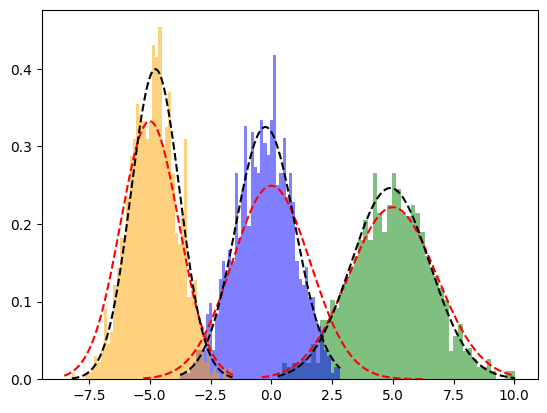

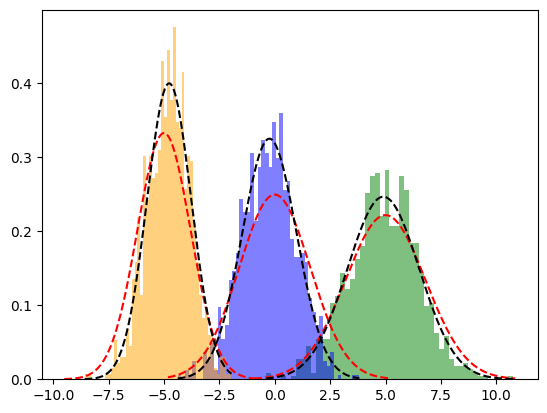

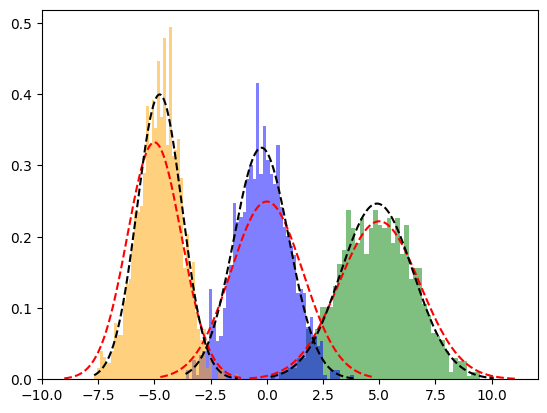

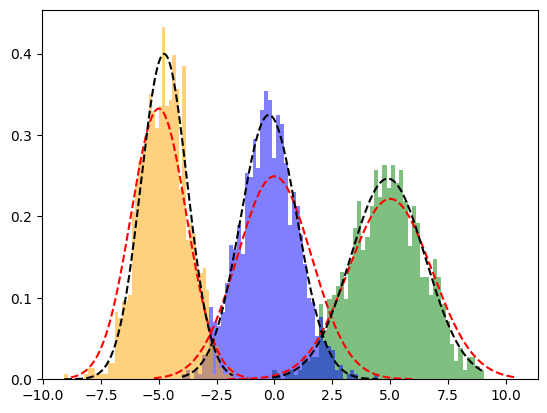

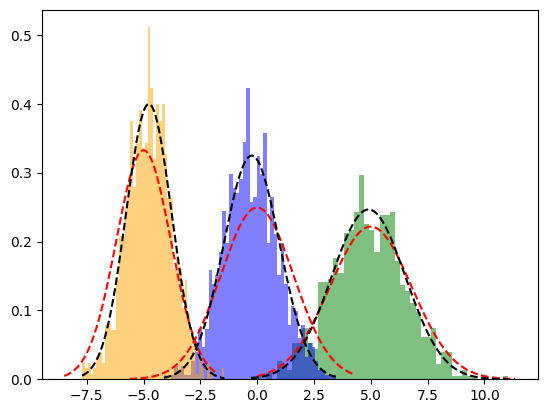

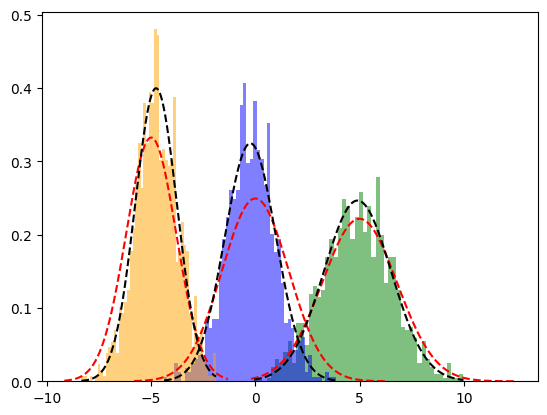

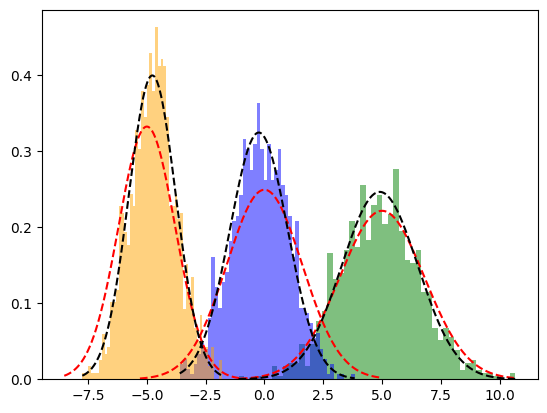

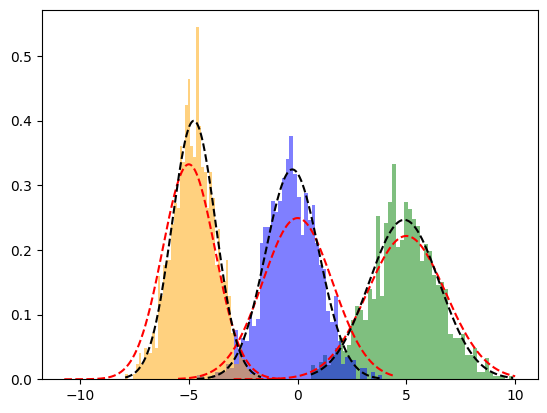

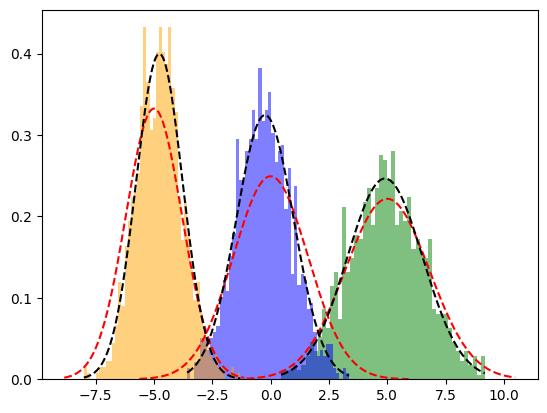

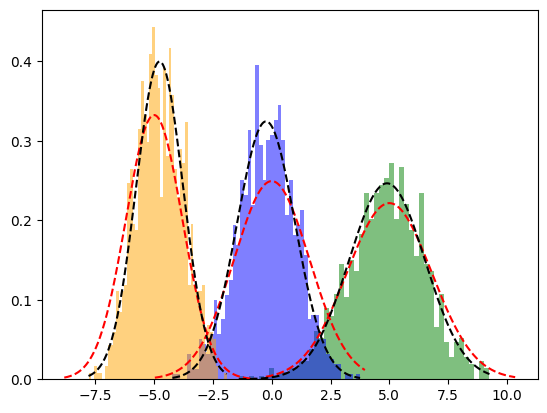

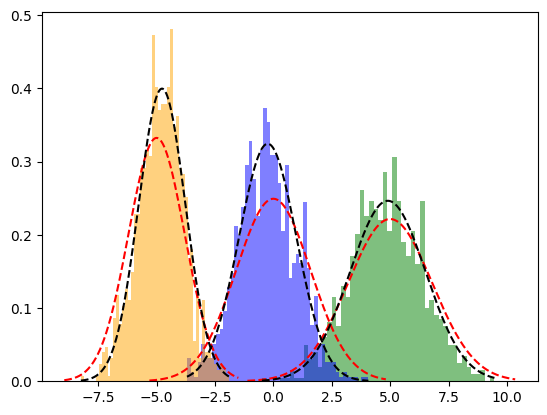

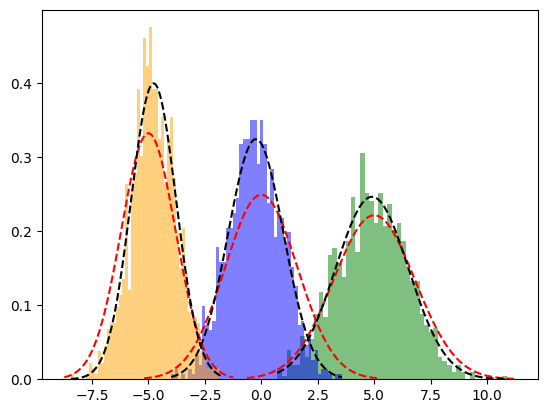

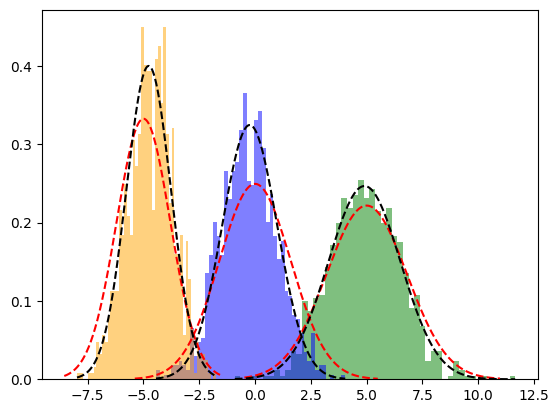

In [49]:
train_gmm(X,n_steps=30,plot_intermediate_steps_flag=True)